In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load the data
file_paths = [
    'Binary Labeled Data/bag_toss_binary.csv',
    #'Binary Labeled Data/sitting_up_and_down_binary.csv',
    #'Binary Labeled Data/stairs_binary.csv',
    'Binary Labeled Data/standing_binary.csv',
    #'Binary Labeled Data/walking_binary.csv'
]
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
combined_data = pd.concat(data_frames)



In [53]:
# Preprocess the data
data_for_model = combined_data.drop(columns=['timestamp'])  # Drop timestamp
X = data_for_model.drop(columns=['label'])
y = data_for_model['label'].values

print(len(y))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print(y_encoded)

sequence_length = 60
step = 5

def create_sequences(X, y, sequence_length, step):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length, step):
        X_seq.append(X[i: i + sequence_length])
        # For simplicity, we take the label of the last timestep in each sequence
        y_seq.append(y[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def create_sequences2(X, y, sequence_length, step, fall_detection_threshold):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length, step):
        seq = X[i: i + sequence_length]
        # Assuming `y` is a binary indicator where 1 represents a fall
        seq_labels = y[i: i + sequence_length]
        
        # Label the sequence as a fall if the fall_detection_threshold is met
        if np.mean(seq_labels) >= fall_detection_threshold:
            label = 1  # Fall detected
        else:
            label = 0  # No fall detected
        
        X_seq.append(seq)
        y_seq.append(label)
    return np.array(X_seq), np.array(y_seq)

# Assuming X_scaled and y_encoded are your scaled features and encoded labels respectively
X_sequences, y_sequences = create_sequences2(X_scaled, y, sequence_length, step, 0.2)

# Reshaping for LSTM
X_sequences = X_sequences.reshape((X_sequences.shape[0], sequence_length, X_scaled.shape[1]))

#print(X_sequences)
#print(y_sequences)
print(np.mean(y_sequences))
# Now, X_sequences and y_sequences can be used for training the LSTM model

4560
[0 0 0 ... 0 0 0]
0.11


{0: 0.5625, 1: 4.5}
Epoch 1/50
9/9 [==============================] - 4s 128ms/step - loss: 0.6434 - accuracy: 0.6875 - val_loss: 0.6393 - val_accuracy: 0.6528
Epoch 2/50
9/9 [==============================] - 0s 43ms/step - loss: 0.5501 - accuracy: 0.6892 - val_loss: 0.5707 - val_accuracy: 0.6667
Epoch 3/50
9/9 [==============================] - 0s 37ms/step - loss: 0.4575 - accuracy: 0.7083 - val_loss: 0.4733 - val_accuracy: 0.6944
Epoch 4/50
9/9 [==============================] - 0s 38ms/step - loss: 0.4081 - accuracy: 0.7240 - val_loss: 0.4289 - val_accuracy: 0.6944
Epoch 5/50
9/9 [==============================] - 0s 39ms/step - loss: 0.3752 - accuracy: 0.7292 - val_loss: 0.3971 - val_accuracy: 0.7083
Epoch 6/50
9/9 [==============================] - 0s 38ms/step - loss: 0.3244 - accuracy: 0.7309 - val_loss: 0.3939 - val_accuracy: 0.7014
Epoch 7/50
9/9 [==============================] - 0s 41ms/step - loss: 0.2801 - accuracy: 0.7361 - val_loss: 0.3382 - val_accuracy: 0.7083
Epoch 

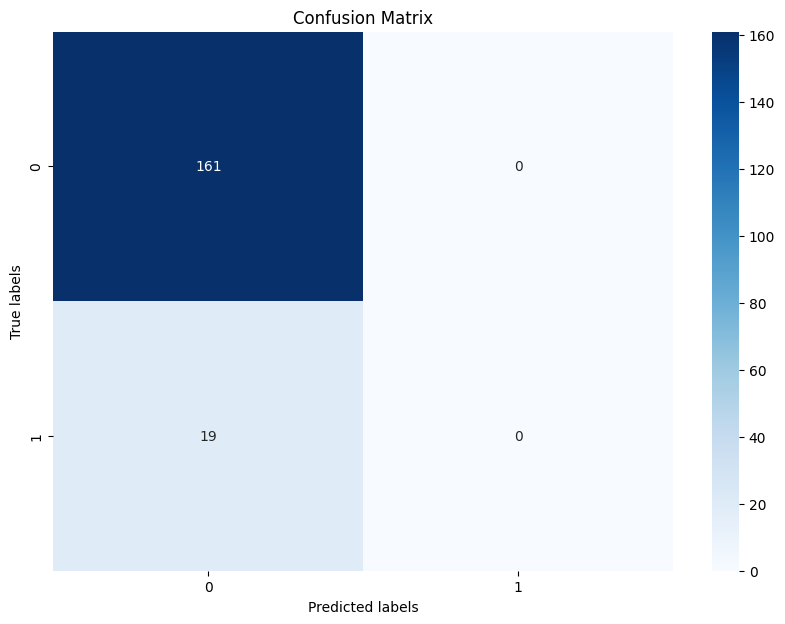

Model and preprocessors saved successfully.


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
#print(X_test)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


# Convert class weights to a dictionary to pass to Keras
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Updated for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with binary labels
model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], batch_size=64, class_weight=class_weight_dict)

# Save the model and preprocessors
model.save('LSTM_model_binary.keras')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Predict the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
print(f"F1 Score: {f1}")

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#plot it
# Plotting confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Model and preprocessors saved successfully.")

In [55]:
from tensorflow.keras.models import load_model

# Load the trained LSTM model
model = load_model('LSTM_model_binary.keras')
# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)



In [56]:
print(X_train)

[[[ 1.98735241e+00 -4.38335096e-02 -6.17077640e-01 -6.37779521e-02
    2.43226885e-02 -3.06195809e-02]
  [ 1.99638536e+00 -2.38188456e-02 -6.27902300e-01 -7.62102042e-02
    2.26323288e-02 -3.57286696e-02]
  [ 1.98956456e+00 -2.02264700e-02 -6.21716780e-01 -6.08709351e-02
    1.67105278e-02 -1.47834146e-02]
  ...
  [-2.13552523e-01 -3.37909764e+00 -9.79123858e-01  6.16203634e+00
   -6.26701592e+00  4.77154217e+00]
  [-3.52900996e-02 -3.88049063e+00 -1.02996110e+00  6.51192165e+00
   -6.09386767e+00  5.22008401e+00]
  [-6.22045916e-02 -3.46582785e+00 -1.45463571e+00  5.89506351e+00
   -5.10951026e+00  5.06937593e+00]]

 [[-4.67765431e-01  1.03952433e+00  7.99213142e-01 -8.57463066e-02
   -2.28033033e+00  2.93599323e+00]
  [-3.63794379e-01  1.05953899e+00  1.05359265e+00  2.11492105e-01
   -2.23107158e+00  2.93241753e+00]
  [-9.46494587e-02  1.10623987e+00  8.44831352e-01  7.21812146e-01
   -2.02726686e+00  2.46241485e+00]
  ...
  [-6.89717817e-01  2.29187034e-01  3.64487065e-01 -1.52906